<a href="https://colab.research.google.com/github/ImperialCollegeLondon/ReCoDE-AIForPatents/blob/main/docs/5_Convolutional_1D_Network_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5. Convolutional 1D Network Classification

A 1D Convolutional Neural Network (CNN) is a type of neural network architecture specifically designed to process one-dimensional sequential data, such as time series or text data. It extends the traditional CNN concept, commonly used for image recognition, to handle sequential data.

The key component of a 1D CNN is the 1D convolutional layer. In this layer, filters/kernels slide along the input data in one dimension, extracting local patterns or features. The filters capture local dependencies between neighboring elements, such as adjacent time steps or words in a sentence. The convolution operation involves element-wise multiplication of the filter weights with the corresponding input values and summing them up, producing a feature map. This type of neural network has been covered in another ReCoDE project, so this notebook won't go too much into the detail of how CNNs work.

**To learn more about Convolutional Neural Networks, refer to Emily Muller's [Perceptions ReCoDE](https://imperialcollegelondon.github.io/recode-perceptions/index.html).**



In [ ]:
!git clone https://github.com/ImperialCollegeLondon/ReCoDE-AIForPatents.git

In [ ]:
##### MODULE IMPORTS #####
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import torch
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Loading the dataset into the workspace and preparing it for use with the ML model

If you want to know how we prepared this dataset, refer to the Web-Scraping Notebook. If you want to learn more about how we prepare the data for use with the model that we train, refer to the Introduction notebook.

In [ ]:
def loaddata(GreenCSV, NotGreenCSV):

  """
  Function to create a training dataset and a validation dataset (the validation
  dataset will be kept aside for when we want to evaluate model, to prevent data
  leakage)
  """

  n=90 #percentage of data that will be used during the training of the machine learning model

  #Read in first dataframe
  GreenData_Dataframe = pd.read_csv(GreenCSV)

  #Read in second dataframe
  NotGreenDataFrame = pd.read_csv(NotGreenCSV)

  #Make sure equal number of entries
  MergedDataFrame = pd.concat([GreenData_Dataframe, NotGreenDataFrame[0:len(GreenData_Dataframe)]])

  #Shuffle dataframe
  MergedDataFrame = MergedDataFrame.sample(frac=1, random_state=25)

  #Get n percent first rows of merged dataframe
  TrainingDataFrame = MergedDataFrame.head(int(len(MergedDataFrame)*(n/100)))

  #Get n percent last rows of merged dataframe
  ValidationDataframe = MergedDataFrame.tail(int(len(MergedDataFrame)*((100-n)/100)))

  #Shuffle training dataframe
  FinalDataframe = TrainingDataFrame.sample(frac=1, random_state=25)

  #Shuffle validation dataframe
  ValidationDataframe = ValidationDataframe.sample(frac=1, random_state=25)

  return FinalDataframe, ValidationDataframe

FinalDataframe, ValidationDataframe = loaddata('/content/ReCoDE-AIForPatents/Datasets/GreenPatents_Dataset.csv',
                          '/content/ReCoDE-AIForPatents/Datasets/NotGreenPatents_Dataset.csv')

# Checking for duplicates
total_duplicate_titles = sum(FinalDataframe["Abstract"].duplicated())

# Deleting duplicates
FinalDataframe = FinalDataframe[~FinalDataframe["Abstract"].duplicated()]

#Deleting Nan values
FinalDataframe = FinalDataframe.dropna()

X_train, X_test, y_train, y_test = train_test_split(
    FinalDataframe["Abstract"].to_numpy(),
    FinalDataframe["GreenV"].to_numpy(),

    # 10% of sample in test dataset
    test_size=0.1,
    random_state=25)

X_val, X_valnull, Y_val, Y_valnull = train_test_split(
    ValidationDataframe["Abstract"].to_numpy(),
    ValidationDataframe["GreenV"].to_numpy(),
    test_size=0.0001,
    random_state=25)

# Setting up the Text Vectoriser

max_vocab_length = 140000
max_length = 50

text_vectoriser = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

#Making inputs compatible with TextVectorisation Layer
X_train = [str(x) for x in X_train]
X_test = [str(x) for x in X_test]
X_train = np.array(X_train)
X_test = np.array(X_test)

#Making validation inputs compatible with TextVectorisation Layer for inference
X_val = [str(x) for x in X_val]
X_val = np.array(X_val)

"""
Allows our vectoriser object to computes a vocabulary of all the string tokens seen in the dataset.
It's sorted by occurrence count, with ties broken by sort order of the tokens (high to low).
"""
text_vectoriser.adapt(X_train)

Vocabulary = text_vectoriser.get_vocabulary()
max_entry_length = 200

#Setting up Callbacks

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", # watch the val loss metric
    patience=5) # if val loss increases for 5 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "Checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

#Pooling Layer for Convolutional Neural Networks



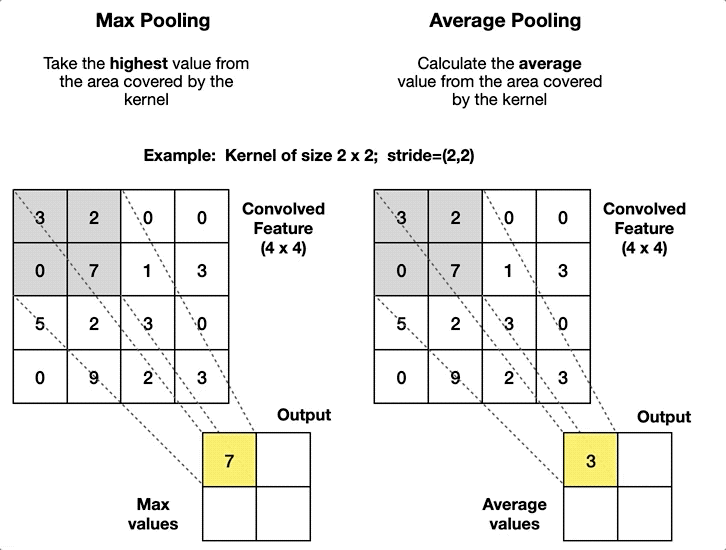

Source: [Introduction To Pooling Layers In CNN](https://pub.towardsai.net/introduction-to-pooling-layers-in-cnn-dafe61eabe34)

The main purpose of a pooling layer in a neural network is to progressively reduce the dimensions (width) of the input data as it passes through the network, while retaining the most important information. The more pooling layers there are in a network, the greater the reduction effect. By reducing the spatial dimensions of the input, pooling layers help to decrease the computational complexity of the network.

Pooling layers summarize the presence of features within their pooling regions. By retaining the most important features while discarding less relevant details, pooling layers can help extract important features and capture the essence of the input data.

Common types of pooling layers include max pooling and average pooling. Max pooling takes the maximum value within each pooling region, while average pooling calculates the average value. These operations help to retain the most prominent features or representative values from the input.

If you would like to learn more about pooling layers, check out this [article](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/) by Machine Learning Mastery.

#Compiling and training 1D CNN using Keras' Functional API.

In [ ]:
#Create embedding layer (new embedding layer for each model)
Convolutional1DNet_Embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=200,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="1DCNN_Embedding")

# Create 1-dimensional Convolutional Neural Network model

"""
Defining the architecture of the 1D CNN

The input to a layer is defined by placing the input layer's variable name in
brackets at the end of the definition of the layer.
"""

# inputs are 1-dimensional string objects
inputs = layers.Input(shape=(1,), dtype="string")

#Tokenise and vectorise inputs
x = text_vectoriser(inputs)

#Create embedding from tokenised inputs
x = Convolutional1DNet_Embedding(x)

"""
Kernel size: An integer or tuple/list of a single integer, specifying the length
of the 1D convolution window.
Filters: Integer, the dimensionality of the output space
(i.e. the number of output filters in the convolution).

"""
x = layers.Conv1D(filters=32,
                  kernel_size=5,
                  activation="relu")(x)

"""
Performs pooling as described above
"""
x = layers.GlobalMaxPool1D()(x)

"""
We only have two possible outputs, so we use sigmoid activation function.

A dense layer is a layer that is deeply connected with its preceding layer which
means the neurons of the layer are connected to every neuron of its preceding layer.
"""

outputs = layers.Dense(1, activation="sigmoid")(x)

#Confirm model architecture by merging input and output layers
Convolutional1DNet = tf.keras.Model(inputs, outputs, name="Conv1D")

# Compile Conv1D model
Convolutional1DNet.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
Convolutional1DNet.summary()

Model: "Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 50)               0         
 torization)                                                     
                                                                 
 1DCNN_Embedding (Embedding)  (None, 50, 128)          17920000  
                                                                 
 conv1d (Conv1D)             (None, 46, 32)            20512     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 33   

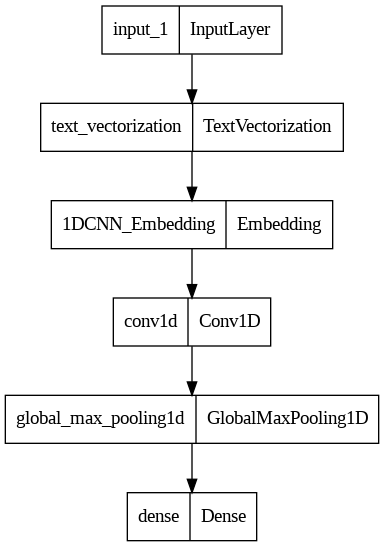

In [ ]:
plot_model(Convolutional1DNet)

In [ ]:
epochs = 20
# Compile model
Convolutional1DNet.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
history = Convolutional1DNet.fit(
    X_train, #Abstract for training
    y_train, #Abstract classes
    epochs=epochs, #Defining epochs
    batch_size=32, #Defining the batch size
    validation_data=(X_test, y_test), #Test data
    callbacks=[early_stopping, model_checkpoint]) #Adding callbacks to the training pipeline

Epoch 1/20
3780/3780 [==============================] - ETA: 0s - loss: 0.2882 - accuracy: 0.8764

3780/3780 [==============================] - 83s 19ms/step - loss: 0.2882 - accuracy: 0.8764 - val_loss: 0.2432 - val_accuracy: 0.8988
Epoch 2/20
3780/3780 [==============================] - 24s 6ms/step - loss: 0.1703 - accuracy: 0.9347 - val_loss: 0.2585 - val_accuracy: 0.8983
Epoch 3/20
3780/3780 [==============================] - 23s 6ms/step - loss: 0.0706 - accuracy: 0.9764 - val_loss: 0.3144 - val_accuracy: 0.8916
Epoch 4/20
3780/3780 [==============================] - 24s 6ms/step - loss: 0.0193 - accuracy: 0.9948 - val_loss: 0.4176 - val_accuracy: 0.8843
Epoch 5/20
3780/3780 [==============================] - 23s 6ms/step - loss: 0.0087 - accuracy: 0.9980 - val_loss: 0.4800 - val_accuracy: 0.8845
Epoch 6/20
3780/3780 [==============================] - 22s 6ms/step - loss: 0.0059 - accuracy: 0.9990 - val_loss: 0.5596 - val_accuracy: 0.8865


#Evaluate Model Training and Performance

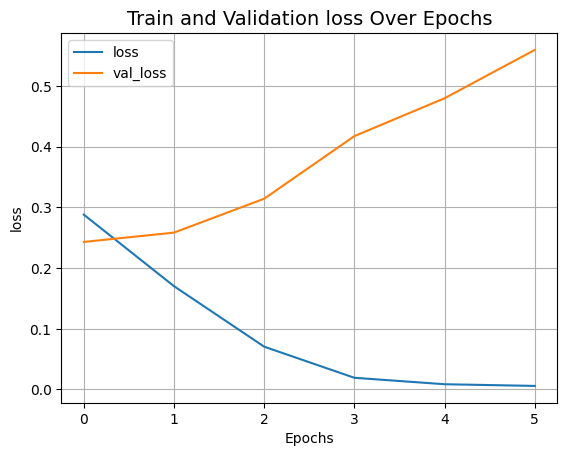

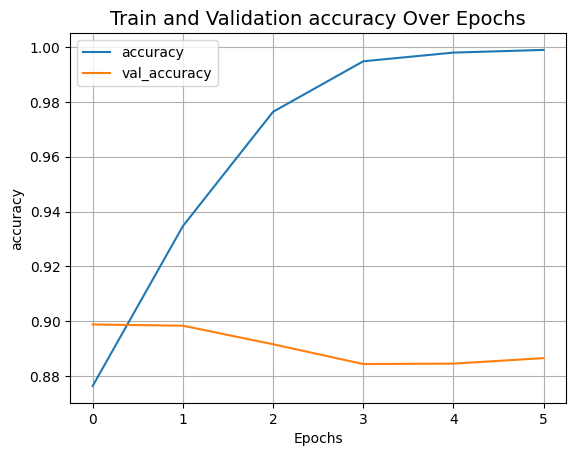

In [ ]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

plot_result("loss")
plot_result("accuracy")

In [ ]:
"""
Function to calculate evaluation metrics. To learn more about evaluation metrics,
refer to the introduction notebook.
"""

def calculate_model_accuracy(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred) * 100
  precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred,
                                                                   average='weighted')

  results = {'accuracy':accuracy,
         'precision': precision,
         'recall': recall,
         'f1': f1_score}

  return results

In [ ]:


Convolutional1DNet_Predictions = Convolutional1DNet.predict(X_val)
Convolutional1DNet_Predictions = tf.squeeze(tf.round(Convolutional1DNet_Predictions))
Convolutional1DNetresult = calculate_model_accuracy(Y_val, Convolutional1DNet_Predictions)
print(Convolutional1DNetresult)

467/467 [==============================] - 1s 2ms/step
{'accuracy': 88.59954478511179, 'precision': 0.8867971722714025, 'recall': 0.885995447851118, 'f1': 0.885960774091304}


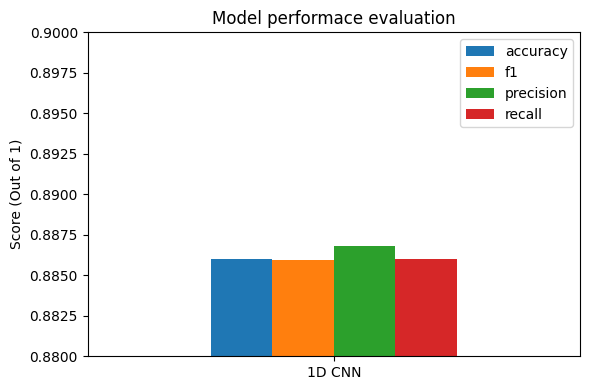

In [ ]:
#Plotting the four metrics on a bar chart
all_results = pd.DataFrame({"1D CNN": Convolutional1DNetresult})
all_results = all_results.transpose() #Formatting our dataframe so it can be plotted as a bar chart
all_results["accuracy"] = all_results["accuracy"]/100 #Normalising our accuracy score so we can plot it on the bar chart
all_results.plot(kind="bar", figsize=(6, 4))
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=0, horizontalalignment="center")
plt.title("Model performace evaluation")
plt.ylabel('Score (Out of 1)')
plt.ylim(0.88, 0.9)
plt.tight_layout()

#Extension Tasks

- Train using Sequential API
- Add more Convolutional and Pooling Layers. Does this make a big difference to the performance of the model?
- What happens when you change the filter and kernel size?
- Train using a GPU to see difference in speed
- Play around with Hyperparameters to see if performance can be improved
- Compare performance of this model with models from the other notebooks
- Try using trained models to predict on text that isn't in the dataset? Are there any situations where the model might get confused? Why might this be?

#What's Next?

Now that we have learned a little more about some of the important concepts in machine learning with CNNs, let's check out some other model architectures!

Check out any of these notebooks:

- PatentClassification_LSTM_Classification
- PatentClassification_Transformer_Classification